### Task2: DS Component Building

#### MLops and components

Though manual model development practices following standard SDLC principles are common, only 20% to 40% of models reach production. **Mlops** brings the benefits we already know to the machine-learning and data science space. A Systems-oriented approach, MLops enables the integration of data science teams developing the models and ML-engineering teams responsible for deployment and maintenance in the production environment. Through CI/CD tools for automating infrastructure management and fast continuous development and testing, both teams will collaborate sharing responsibilities and avoiding “merge-hells” for better performance. Unique to Mlops is the addition of Models and Data as artifacts to be developed/version/served/evaluated/maintained to the Codebase running on top of the two following best practices from DevOps. Here both teams will share responsibilities and collaborate according to the best capability task fit.

The five components of Mlops **Training-operationalization** and **Continuous-training** on the development side and **Prediction-serving** and **Continuous-monitoring** on the deployment side plus **Data-and-model-management** acting as a bridge inbetween enable workflow automation and integration.

In [6]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [7]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

### Data Loading

In [8]:
# Initialize DataLoader
data_loader = SlackDataLoader(rpath+'/data/anonymized')

# Load data from a Slack channel
channels = data_loader.get_channels()
users = data_loader.get_users()
userNamesById, userIdsByName = data_loader.get_user_map()
channelNamesById, channelIdsByName = data_loader.get_channel_map()
all_channels_slack_data = {}
all_channels_slack_reactions = {}
for channel in channels:
    ch_path = rpath+'/data/anonymized/'+channel["name"]+'/'
    all_channels_slack_reactions[channel["id"]] = data_loader.parse_slack_reaction(ch_path, channel["name"])
    all_channels_slack_data[channel["id"]] = data_loader.slack_parser(ch_path)

### 1) What is the distribution of time differences between messages, replies, reactions, and any type event (message, reply, reaction)?

In [58]:
slack_msgs = all_channels_slack_data[channelIdsByName["all-community-building"]]
all_msg_ts = []
all_rpl_ts = []
for ch_id, ch_data in all_channels_slack_data.items():
    all_msg_ts.append(ch_data['msg_sent_time'])
    all_rpl_ts.append(ch_data['time_thread_start'])
#flatten
flat_all_msg_ts = [item/86400 for sublist in all_msg_ts for item in sublist]
flat_all_rpl_ts = [item/86400 for sublist in all_rpl_ts for item in sublist]
#sort
flat_all_msg_ts.sort()
flat_all_rpl_ts.sort()
#drope the first zeros(the msgs without replies)
flat_all_rpl_ts = flat_all_rpl_ts[next((i for i, x in enumerate(flat_all_rpl_ts) if x), None):]

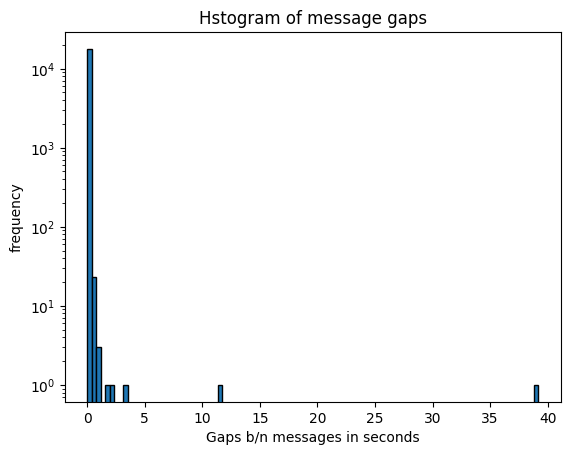

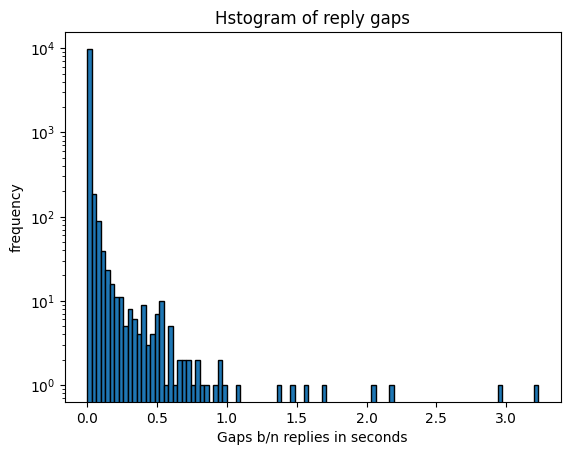

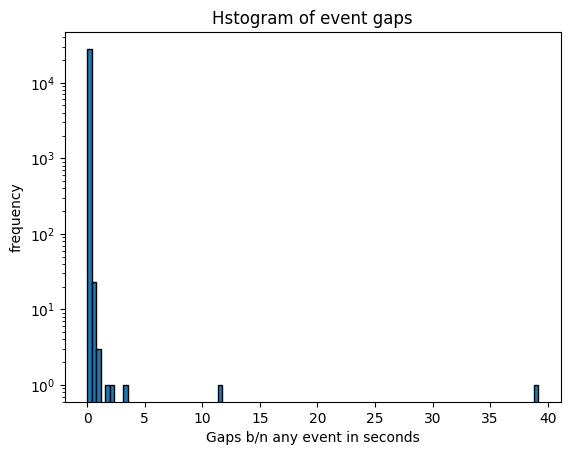

In [72]:
#Plot a histogram of the time difference between Consecutive messages
msg_gaps = [flat_all_msg_ts[i + 1] - flat_all_msg_ts[i] for i in range(len(flat_all_msg_ts)-1)]
plt.hist(msg_gaps, bins=100, edgecolor='black')
plt.yscale("log")
plt.xlabel('Gaps b/n messages in seconds')
plt.ylabel('frequency')
plt.title("Hstogram of message gaps")
plt.show()
#Plot a histogram of the time difference between Consecutive replies
rpl_gaps = [flat_all_rpl_ts[i + 1] - flat_all_rpl_ts[i] for i in range(len(flat_all_rpl_ts)-1)]
plt.hist(rpl_gaps, bins=100, edgecolor='black')
plt.yscale("log")
plt.xlabel('Gaps b/n replies in seconds')
plt.ylabel('frequency')
plt.title("Hstogram of reply gaps")
plt.show()
#Plot a histogram of the time difference between Consecutive reactions
#timestam of rection missing in the dataset

#Plot a histogram of the time difference between Consecutive events (message, reply, reaction)
#merge the msg and rpl time stamsps
all_ts = flat_all_msg_ts + flat_all_rpl_ts
all_ts.sort()
all_gaps = [all_ts[i + 1] - all_ts[i] for i in range(len(all_ts)-1)]
plt.hist(all_gaps, bins=100, edgecolor='black')
plt.yscale("log")
plt.xlabel('Gaps b/n any event in seconds')
plt.ylabel('frequency')
plt.title("Hstogram of event gaps")
plt.show()


### 2) Create ML models for message classification, topic modelling, and sentiment analysis and answer the following question

#### What are the top 10 topics of the different channels?

In [ ]:
dm_outline = '''Add your answer text here
you can create python string using (') or (") or 3('), like the text here. The 3(') string can be used
to write paragraphs, comments in the beginning of functions, etc.. Your answer to the above question
should replace this text.
'''

#### What is the sentiment of messages as a function of the number of days since the start of the training?

In [ ]:
assert len(dm_outline) > 100
### BEGIN HIDDEN TESTS
assert len(dm_outline) > 70
### END HIDDEN TESTS

#### Model Evaluation

### 3) Model versioning with MLFlow

In [ ]:
assert len(how_success) > 100
### BEGIN HIDDEN TESTS
assert len(how_success) > 80
### END HIDDEN TESTS